## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *

# Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32
n_iters = 5_000

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/Downloads/bgi_pbmc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Abbreviation",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'single_cell_od' #'overdispersed_bulk'
)

# Run Deconvolution

In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 10,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000, clear_param_store=True)

[step: 0, time: 1 s ] loss: 13159945.30
[step: 1000, time: 15 s ] loss: 3555789.54
[step: 2000, time: 31 s ] loss: 1758478.40
[step: 3000, time: 48 s ] loss: 1169733.27
[step: 4000, time: 64 s ] loss: 922412.90


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

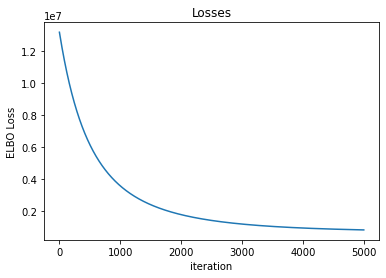

In [9]:
# Plot the loses
pseudo_time_reg_deconv.plot_loss()

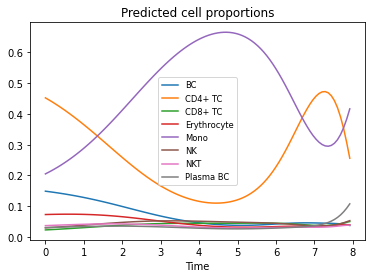

In [10]:
# calculate and plot the composition trajectories
#pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

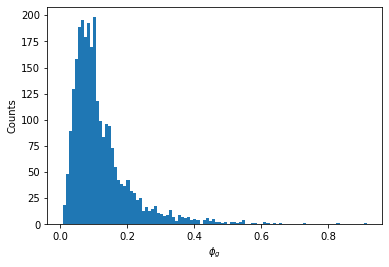

In [11]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

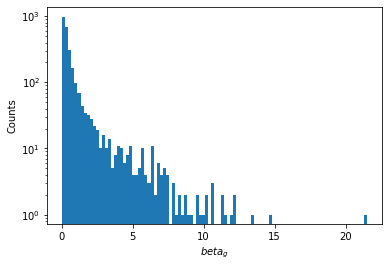

In [12]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

/home/nbarkas/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/nbarkas/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=Tr

Text(0.5, 1.0, 'Last few Dirichlet $ \\alpha $ Values')

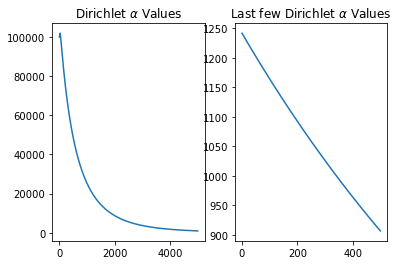

In [13]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')


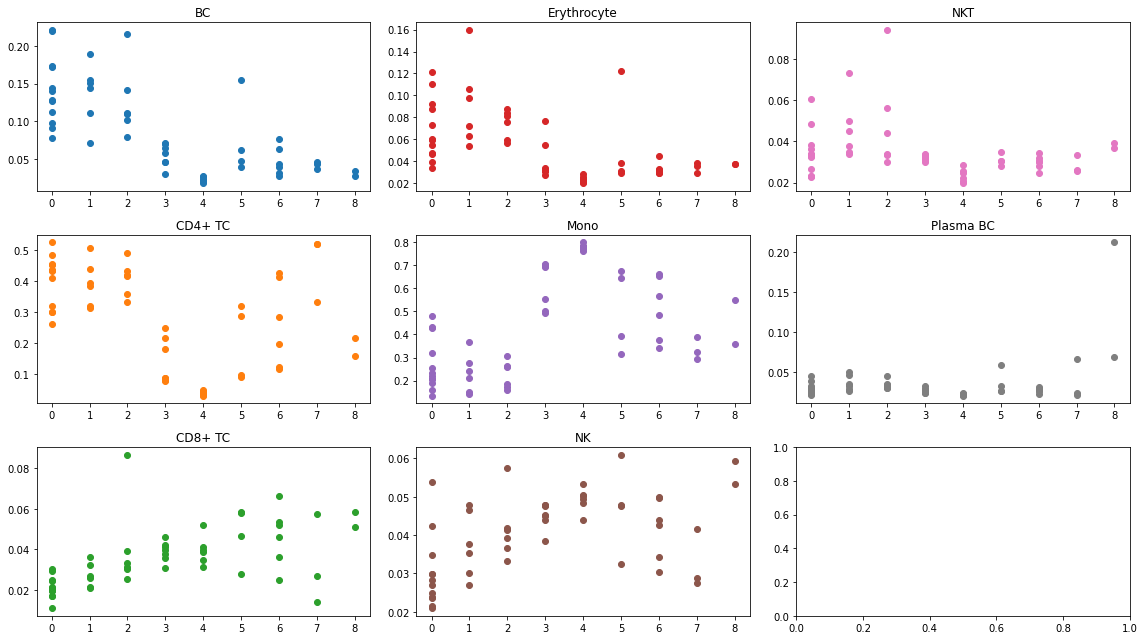

In [14]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

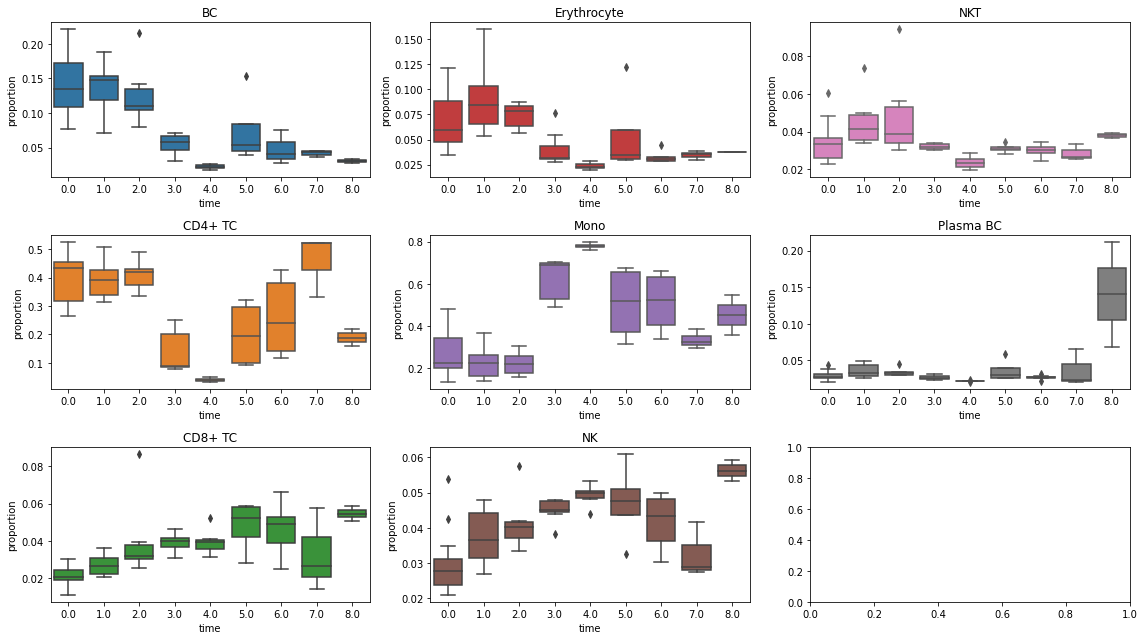

In [15]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()